# Image Classifier

## Setup and load data

In [34]:
!pip install tensorflow opencv-python matplotlib

In [35]:
!pip list

Package                       Version
----------------------------- --------------------
absl-py                       1.4.0
alabaster                     0.7.12
anaconda-client               1.11.0
anaconda-navigator            2.3.1
anaconda-project              0.11.1
anyio                         3.5.0
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arrow                         1.2.2
astroid                       2.11.7
astropy                       5.1
astunparse                    1.6.3
atomicwrites                  1.4.0
attrs                         21.4.0
Automat                       20.2.0
autopep8                      1.6.0
Babel                         2.9.1
backcall                      0.2.0
backports.functools-lru-cache 1.6.4
backports.tempfile            1.0
backports.weakref             1.0.post1
bcrypt                        3.2.0
beautifulsoup4                4.11.1
binaryornot                   0.4.4
bi

In [36]:
import tensorflow as tf
import os

In [37]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

In [38]:
##Remove Dodgy Images
import cv2
import imghdr

In [39]:
data_dir = 'data'

In [40]:
image_exts = ['jpeg','jpg','bmp','png']

In [41]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

## LOAD DATA

In [42]:
import numpy as np
from matplotlib import pyplot as plt

In [43]:
data = tf.keras.utils.image_dataset_from_directory('data')


Found 148 files belonging to 2 classes.


In [44]:
data_iterator = data.as_numpy_iterator()

In [45]:
batch = data_iterator.next()

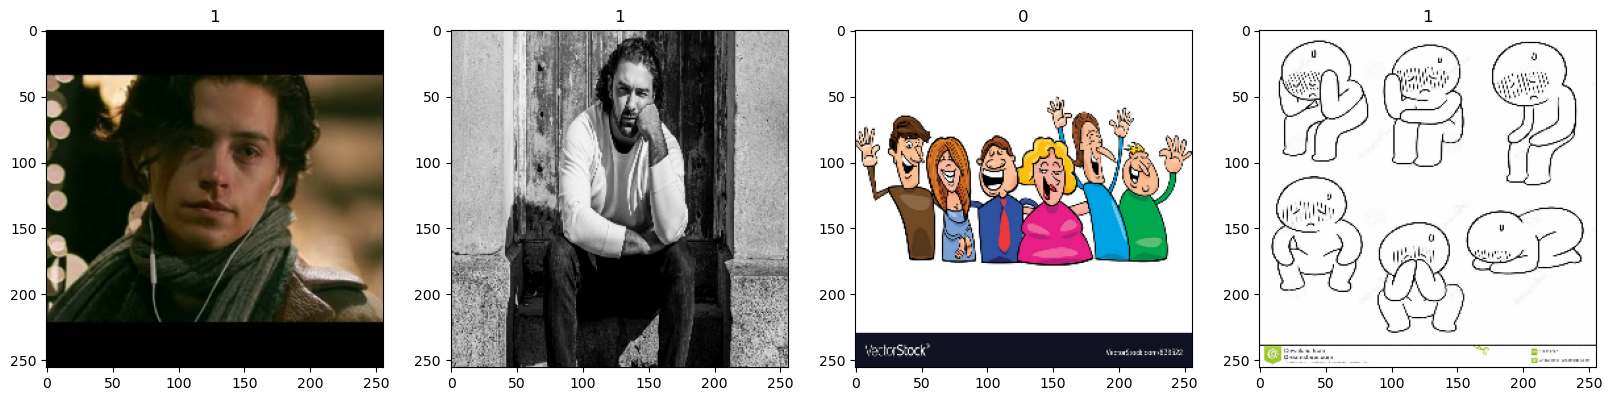

In [46]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [47]:
## 1 == SAD
## 0 == HAPPY

#SCALING DATA

In [48]:
data = data.map(lambda x,y: (x/255, y))

In [49]:
data.as_numpy_iterator().next()

(array([[[[0.91803   , 0.9494026 , 0.9572457 ],
          [0.9456495 , 0.9613358 , 0.96525735],
          [0.9611673 , 0.9690104 , 0.96508884],
          ...,
          [0.9843137 , 0.9843137 , 0.9843137 ],
          [0.9843137 , 0.9843137 , 0.9843137 ],
          [0.9843137 , 0.9843137 , 0.9843137 ]],
 
         [[0.90605086, 0.9374234 , 0.94526654],
          [0.93383884, 0.9495251 , 0.9534467 ],
          [0.9578431 , 0.96568626, 0.9617647 ],
          ...,
          [0.9843137 , 0.9843137 , 0.9843137 ],
          [0.9843137 , 0.9843137 , 0.9843137 ],
          [0.9843137 , 0.9843137 , 0.9843137 ]],
 
         [[0.90294117, 0.9343137 , 0.94215685],
          [0.92941177, 0.94509804, 0.9490196 ],
          [0.9538756 , 0.96171874, 0.95779717],
          ...,
          [0.98039216, 0.98039216, 0.98039216],
          [0.9843137 , 0.9843137 , 0.9843137 ],
          [0.98039216, 0.98039216, 0.98039216]],
 
         ...,
 
         [[0.9139093 , 0.93351716, 0.94920343],
          [0.91484

#SPLIT DATA

In [50]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [51]:
train_size

3

In [52]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

## BUILDING THE MODEL

In [53]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [54]:
model = Sequential()

In [55]:
model.add(Conv2D(16, (3,3), 1, activation='relu',input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

 

In [56]:
model.compile('adam',loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [57]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 127, 127, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 30, 30, 16)       

## TRAINING

In [58]:
logdir = 'logs'

In [60]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [61]:
hsit = model.fit(train,epochs=20,validation_data=val,callbacks=[tensorboard_callback])

Epoch 1/20
3/3 [==============================] - 15s 3s/step - loss: 1.7060 - accuracy: 0.4896 - val_loss: 1.4401 - val_accuracy: 0.3750
Epoch 2/20
3/3 [==============================] - 11s 3s/step - loss: 0.9110 - accuracy: 0.4896 - val_loss: 0.7681 - val_accuracy: 0.4688
Epoch 3/20
3/3 [==============================] - 11s 3s/step - loss: 0.6837 - accuracy: 0.5417 - val_loss: 0.5472 - val_accuracy: 0.5625
Epoch 4/20
3/3 [==============================] - 11s 3s/step - loss: 0.5739 - accuracy: 0.6562 - val_loss: 0.6027 - val_accuracy: 0.8125
Epoch 5/20
3/3 [==============================] - 11s 3s/step - loss: 0.5610 - accuracy: 0.8542 - val_loss: 0.5215 - val_accuracy: 0.8125
Epoch 6/20
3/3 [==============================] - 10s 3s/step - loss: 0.5003 - accuracy: 0.8333 - val_loss: 0.3682 - val_accuracy: 0.9375
Epoch 7/20
3/3 [==============================] - 11s 3s/step - loss: 0.3799 - accuracy: 0.8125 - val_loss: 0.2727 - val_accuracy: 0.8750
Epoch 8/20
3/3 [==================

## Plotting Performance

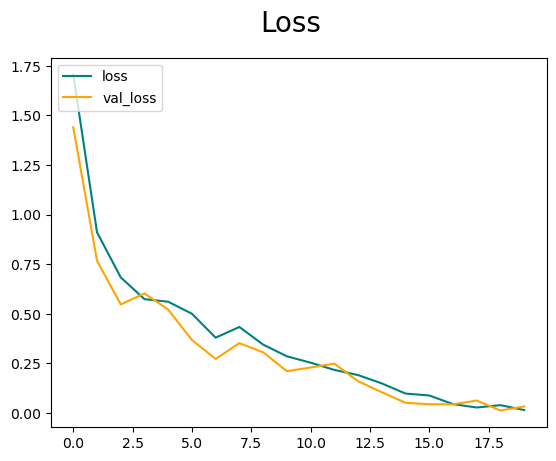

In [65]:
fig = plt.figure()
plt.plot(hsit.history['loss'], color='teal', label='loss')
plt.plot(hsit.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

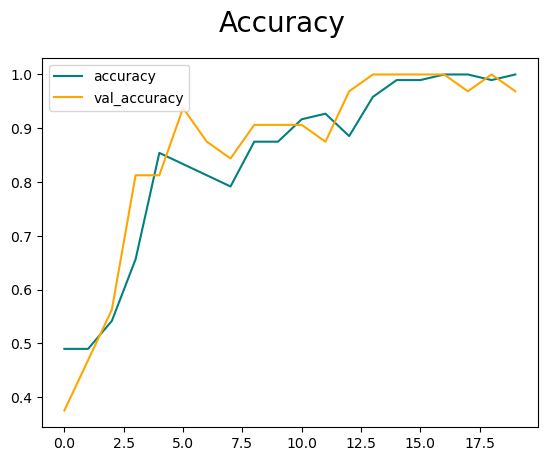

In [66]:
fig = plt.figure()
plt.plot(hsit.history['accuracy'], color='teal', label='accuracy')
plt.plot(hsit.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

## Evaluate Performance

In [67]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [68]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [69]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

In [75]:
print(f'Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}')

Precision: 0.0, Recall: 0.0, Accuracy: 0.0


In [76]:
import cv2

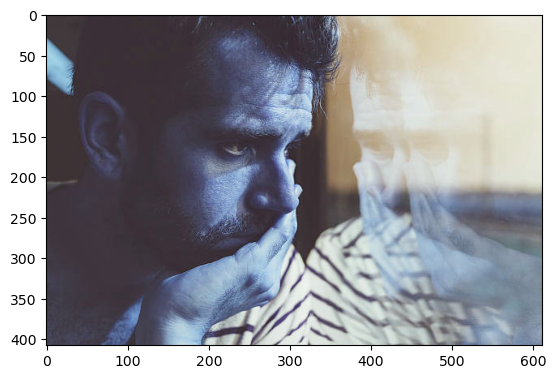

In [83]:
img = cv2.imread('sad_test.jpg')
plt.imshow(img)
plt.show()

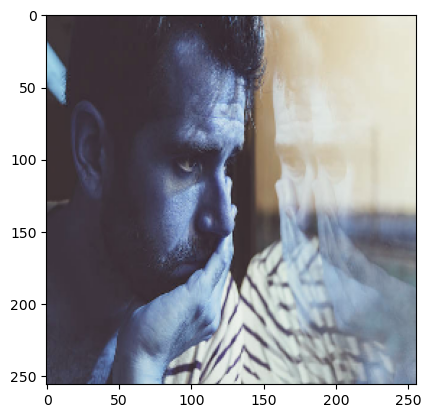

In [84]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [85]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 93ms/step


In [86]:
yhat

array([[0.7710011]], dtype=float32)

In [87]:
if yhat > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Sad


## Save the MODEL

In [88]:
from tensorflow.keras.models import load_model

In [89]:
model.save(os.path.join('models','imageclassifier.h5'))

C:\Users\KIIT\anaconda4\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
NEW